<a href="https://colab.research.google.com/github/UlkuTuncerKucuktas/MURA_DATASET_DENSENET/blob/main/Mura_Dataset_Densenet_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Google Drive içerisindebulunan dataset arşivini colab üzerine açtım.
!unzip "/content/drive/My Drive/Mura_Dataset.rar"

Görüntülenen çıkış son 5000 satıra kısaltıldı.
   creating: MURA-v1.1/train/XR_SHOULDER/patient01061/
   creating: MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image1.png  
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image3.png  
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01061/study1_positive/image2.png  
   creating: MURA-v1.1/train/XR_SHOULDER/patient01016/
   creating: MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image1.png  
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image3.png  
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01016/study1_positive/image2.png  
   creating: MURA-v1.1/train/XR_SHOULDER/patient01182/
   creating: MURA-v1.1/train/XR_SHOULDER/patient01182/study1_positive/
  inflating: MURA-v1.1/train/XR_SHOULDER/patient01182/study1_positive/image1.

In [2]:
#Data set içerisinde data path bulunan csv dosyalarını okudum.

import pandas as pd
TrainCsvFile = pd.read_csv("/content/MURA-v1.1/train_image_paths.csv", names = ["Path"])
ValidCsvFile = pd.read_csv("/content/MURA-v1.1/valid_image_paths.csv",names = ["Path"])

In [3]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101


In [5]:
import PIL
from PIL import Image
from matplotlib.pyplot import imshow
import numpy as np
from tqdm import tqdm
positivefilepath = "/content/Image_Folder/train/positive"#

negativefilepath = "/content/Image_Folder/train/negative"

validpositivefilepath = "/content/Image_Folder/val/positive"

validnegativefilepath = "/content/Image_Folder/val/negative"


#Pytorch kütüphenesinde bulunan ImageFolder dataframe hazırlama fonksiyonundan yararlanmak için
#bizim elimizde bulunan data directory dizini üzerinde değişiklikler yapmak amacı ile yardımcı
#fonksiyon
def ImageFolderCreator(csvfilepath , positivefilepath , negativefilepath):
  for i in tqdm(range(csvfilepath.shape[0])):
    img = Image.open("/content/" + csvfilepath[i])
    img = img.resize((224,224))
    img = img.convert('RGB')
    
    if "positive" in csvfilepath[i]:
      img.save(positivefilepath + "/img{}.png".format(i),"PNG")
    if "negative" in csvfilepath[i]:
      img.save(negativefilepath + "/img{}.png".format(i),"PNG")

ImageFolderCreator(TrainCsvFile['Path'],positivefilepath,negativefilepath)
ImageFolderCreator(ValidCsvFile['Path'],validpositivefilepath,validnegativefilepath)
  

100%|██████████| 3197/3197 [00:49<00:00, 64.45it/s]


In [6]:

#Image Folder için path
data_dir = "/content/Image_Folder/"

#Pytorch eğitimlerinde ağı fine tunin için yazılmış fonksiyonu kullanak amacı ile
#gereken değişken
model_name = "densenet"

# Colab içerisinde bulunan ipynp dosyalarınıda class olarak saydığından dolayı 3
# aslında gereken abnormal ve normal yani 2
num_classes = 3

# Batch size 
batch_size = 8

#  epochs sayısı
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True

In [7]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Her epoch için valid ve train fazları var
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # modeli train moda alır
            else:
                model.eval()   # modeli eval moda alır

            running_loss = 0.0
            running_corrects = 0

            # data içerisinde gezmek için.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, val_acc_history

In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
import torchvision.models as models
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    #Seçeceğimiz ağ için parametreleri fine tune eder
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)
print(input_size)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth



DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [10]:
#Data pre process işlemleri
#Çoğu pre trained data 3,224,224 size ve normalize işlemi gerektirir
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Training ve validation datasetleri oluşturur
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Training ve validation dataloaderları oluşturur
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# GPU durumunu kontrol eder
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [21]:
# Modeli GPU ya oluşturur
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(params_to_update, lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)


Params to learn:
	 classifier.weight
	 classifier.bias


In [22]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs,is_inception=False)

Epoch 0/14
----------
train Loss: 0.7311 Acc: 0.6701
val Loss: 0.7128 Acc: 0.6578

Epoch 1/14
----------
train Loss: 0.6398 Acc: 0.6714
val Loss: 0.7613 Acc: 0.6375

Epoch 2/14
----------
train Loss: 0.6311 Acc: 0.6752
val Loss: 0.7351 Acc: 0.6090

Epoch 3/14
----------
train Loss: 0.6246 Acc: 0.6778
val Loss: 0.7298 Acc: 0.6337

Epoch 4/14
----------
train Loss: 0.6277 Acc: 0.6732
val Loss: 0.5772 Acc: 0.6941

Epoch 5/14
----------
train Loss: 0.6293 Acc: 0.6701
val Loss: 0.6477 Acc: 0.6637

Epoch 6/14
----------
train Loss: 0.6156 Acc: 0.6800
val Loss: 0.6210 Acc: 0.6775

Epoch 7/14
----------
train Loss: 0.6237 Acc: 0.6738
val Loss: 0.6242 Acc: 0.6831

Epoch 8/14
----------
train Loss: 0.6217 Acc: 0.6762
val Loss: 0.5826 Acc: 0.6975

Epoch 9/14
----------
train Loss: 0.6197 Acc: 0.6765
val Loss: 0.6000 Acc: 0.6910

Epoch 10/14
----------
train Loss: 0.6144 Acc: 0.6777
val Loss: 0.5826 Acc: 0.6947

Epoch 11/14
----------
train Loss: 0.6169 Acc: 0.6763
val Loss: 0.6559 Acc: 0.6544

Ep

In [23]:
historyarr = []

[historyarr.append(hist[i].item()) for i in range(15)]


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

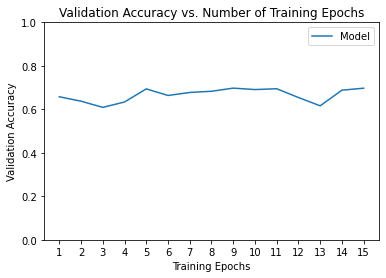

In [24]:
plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),historyarr,label="Model")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
while True:
  pass